# Regularized data programming: Low data regime experiments

RNA time-course dataset.

## Preamble

In [1]:
# Importations.
import torch
import numpy as np
import sys
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier # Linear SVM.
from sklearn import metrics
import itertools
import random

# Personal scripts.
from ratner_mle import RatnerMLE
from bayesian_dp import BayesianDP
from utils import Utils
from train_test import Trainer

# View versioning.
print("python version:", sys.version)
print("\ntorch version:", torch.__version__)
print("numpy version:", np.__version__)
print("seaborn version:", sns.__version__)
print("matplotlib version:", matplotlib.__version__)
print("pandas version:", pd.__version__)
print("sklearn version:", sklearn.__version__)

python version: 3.8.8 (default, Apr 13 2021, 12:59:45) 
[Clang 10.0.0 ]

torch version: 1.7.1
numpy version: 1.22.3
seaborn version: 0.11.1
matplotlib version: 3.3.4
pandas version: 1.2.4
sklearn version: 0.24.1


In [2]:
!pip freeze > requirements.txt

## Read data

In [2]:
# Read in labeling function matrix files.
df_train = pd.read_csv("../data/rna_titles/rna_tuned_lf_matrix_train.csv")
df_val = pd.read_csv("../data/rna_titles/rna_tuned_lf_matrix_val.csv")
df_test = pd.read_csv("../data/rna_titles/rna_tuned_lf_matrix_test.csv")

# Explore.
print("\n---------------------------")
print("TRAINING DATA:")
print("---------------------------\n")
print(df_train.info())
display(df_train)

print("---------------------------")
print("VALIDATION DATA:")
print("---------------------------\n")
print(df_val.info())
display(df_val)

print("---------------------------")
print("TEST DATA:")
print("---------------------------\n")
print(df_test.info())
display(df_test)


---------------------------
TRAINING DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        1656 non-null   int64
 1   1        1656 non-null   int64
 2   2        1656 non-null   int64
 3   Label    1656 non-null   int64
 4   Snorkel  1656 non-null   int64
dtypes: int64(5)
memory usage: 64.8 KB
None


,0,1,2,Label,Snorkel
0,0,0,1,1,1
1,0,0,1,-1,1
2,0,-1,1,-1,-1
3,0,0,1,1,1
4,0,0,-1,-1,-1
...,...,...,...,...,...
1651,0,0,1,1,1
1652,0,-1,1,-1,-1
1653,0,-1,-1,-1,-1
1654,0,-1,-1,-1,-1


---------------------------
VALIDATION DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        184 non-null    int64
 1   1        184 non-null    int64
 2   2        184 non-null    int64
 3   Label    184 non-null    int64
 4   Snorkel  184 non-null    int64
dtypes: int64(5)
memory usage: 7.3 KB
None


,0,1,2,Label,Snorkel
0,0,0,-1,-1,-1
1,0,-1,1,-1,-1
2,0,0,1,1,1
3,0,0,1,1,1
4,0,-1,-1,-1,-1
...,...,...,...,...,...
179,0,0,1,1,1
180,0,0,-1,-1,-1
181,0,-1,-1,-1,-1
182,0,-1,1,-1,-1


---------------------------
TEST DATA:
---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype
---  ------   --------------  -----
 0   0        460 non-null    int64
 1   1        460 non-null    int64
 2   2        460 non-null    int64
 3   Label    460 non-null    int64
 4   Snorkel  460 non-null    int64
dtypes: int64(5)
memory usage: 18.1 KB
None


,0,1,2,Label,Snorkel
0,0,0,1,1,1
1,0,0,-1,-1,-1
2,0,0,1,-1,1
3,0,0,1,1,1
4,0,0,1,1,1
...,...,...,...,...,...
455,0,0,1,1,1
456,0,0,-1,-1,-1
457,0,-1,-1,-1,-1
458,0,0,1,1,1


In [3]:
# Read in raw text data.
df_train_raw = pd.read_csv("../data/rna_titles/rna_tuned_train.csv")
df_val_raw = pd.read_csv("../data/rna_titles/rna_tuned_val.csv")
df_test_raw = pd.read_csv("../data/rna_titles/rna_tuned_test.csv")

# Explore_raw.
print("\n---------------------------")
print("TRAINING DATA:\n")
print("---------------------------\n")
print(df_train_raw.info())
display(df_train_raw)

print("\n---------------------------")
print("VALIDATION DATA:\n")
print("---------------------------\n")
print(df_val_raw.info())
display(df_val_raw)

print("\n---------------------------")
print("TEST DATA:\n")
print("---------------------------\n")
print(df_test_raw.info())
display(df_test_raw)


---------------------------
TRAINING DATA:

---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1656 entries, 0 to 1655
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              1656 non-null   int64 
 1   Title             1656 non-null   object
 2   Authors           1655 non-null   object
 3   Citation          1656 non-null   object
 4   First Author      1655 non-null   object
 5   Journal/Book      1656 non-null   object
 6   Publication Year  1656 non-null   int64 
 7   Create Date       1656 non-null   object
 8   PMCID             943 non-null    object
 9   NIHMS ID          149 non-null    object
 10  DOI               1656 non-null   object
 11  Label             1656 non-null   int64 
dtypes: int64(3), object(9)
memory usage: 155.4+ KB
None


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Label
0,21205307,time-series clustering of gene expression in i...,"Ghandhi SA, Sinha A, Markatou M, Amundson SA.",BMC Genomics. 2011 Jan 4;12:2. doi: 10.1186/14...,Ghandhi SA,BMC Genomics,2011,2011/01/06,PMC3022823,NaN,10.1186/1471-2164-12-2,1
1,25409906,dynamic analyses of alternative polyadenylatio...,"Xia Z, Donehower LA, Cooper TA, Neilson JR, Wh...",Nat Commun. 2014 Nov 20;5:5274. doi: 10.1038/n...,Xia Z,Nat Commun,2014,2014/11/21,PMC4467577,NIHMS674338,10.1038/ncomms6274,0
2,14984408,temporal and spatial patterns of kv1.1 and kv1...,"Karimi-Abdolrezaee S, Eftekharpour E, Fehlings...",Eur J Neurosci. 2004 Feb;19(3):577-89. doi: 10...,Karimi-Abdolrezaee S,Eur J Neurosci,2004,2004/02/27,NaN,NaN,10.1111/j.0953-816x.2004.03164.x,0
3,19340919,simultaneously segmenting multiple gene expres...,"Tadepalli S, Ramakrishnan N, Watson LT, Mishra...",J Bioinform Comput Biol. 2009 Apr;7(2):339-56....,Tadepalli S,J Bioinform Comput Biol,2009,2009/04/03,NaN,NaN,10.1142/s0219720009004114,1
4,18547802,rna dynamics: it is about time,"Al-Hashimi HM, Walter NG.",Curr Opin Struct Biol. 2008 Jun;18(3):321-9. d...,Al-Hashimi HM,Curr Opin Struct Biol,2008,2008/06/13,PMC2580758,NIHMS74438,10.1016/j.sbi.2008.04.004,0
...,...,...,...,...,...,...,...,...,...,...,...,...
1651,17477490,state space modeling of yeast gene expression ...,"Haavisto O, Hyötyniemi H, Roos C.",J Bioinform Comput Biol. 2007 Feb;5(1):31-46. ...,Haavisto O,J Bioinform Comput Biol,2007,2007/05/05,NaN,NaN,10.1142/s0219720007002515,1
1652,15037511,inferring dynamic architecture of cellular net...,"Sontag E, Kiyatkin A, Kholodenko BN.",Bioinformatics. 2004 Aug 12;20(12):1877-86. do...,Sontag E,Bioinformatics,2004,2004/03/24,NaN,NaN,10.1093/bioinformatics/bth173,0
1653,28056486,dynamics of bridge helix bending in rna polyme...,"Wang ZF, Fu YB, Wang PY, Xie P.",Proteins. 2017 Apr;85(4):614-629. doi: 10.1002...,Wang ZF,Proteins,2017,2017/01/06,NaN,NaN,10.1002/prot.25239,0
1654,34149304,first comparison of conventional activated slu...,"Kumar M, Kuroda K, Joshi M, Bhattacharya P, Ba...",Chem Eng J. 2021 Dec 1;425:130635. doi: 10.101...,Kumar M,Chem Eng J,2021,2021/06/21,PMC8200644,NaN,10.1016/j.cej.2021.130635,0



---------------------------
VALIDATION DATA:

---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              184 non-null    int64 
 1   Title             184 non-null    object
 2   Authors           184 non-null    object
 3   Citation          184 non-null    object
 4   First Author      184 non-null    object
 5   Journal/Book      184 non-null    object
 6   Publication Year  184 non-null    int64 
 7   Create Date       184 non-null    object
 8   PMCID             108 non-null    object
 9   NIHMS ID          23 non-null     object
 10  DOI               184 non-null    object
 11  Label             184 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 17.4+ KB
None


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Label
0,27249342,recent advances in dynamic m6a rna modification,"Cao G, Li HB, Yin Z, Flavell RA.",Open Biol. 2016 Apr;6(4):160003. doi: 10.1098/...,Cao G,Open Biol,2016,2016/06/02,PMC4852458,NaN,10.1098/rsob.160003,0
1,16420705,discovery of time-delayed gene regulatory netw...,"Li X, Rao S, Jiang W, Li C, Xiao Y, Guo Z, Zha...",BMC Bioinformatics. 2006 Jan 18;7:26. doi: 10....,Li X,BMC Bioinformatics,2006,2006/01/20,PMC1386718,NaN,10.1186/1471-2105-7-26,0
2,27409645,evaluation of immortalized avpv- and arcuate-s...,"Jacobs DC, Veitch RE, Chappell PE.",Endocrinology. 2016 Sep;157(9):3410-9. doi: 10...,Jacobs DC,Endocrinology,2016,2016/07/14,NaN,NaN,10.1210/en.2016-1294,1
3,29615554,flying the rna nest: drosophila reveals novel ...,"Lefebvre FA, Lécuyer É.",J Dev Biol. 2018 Mar 7;6(1):5. doi: 10.3390/jd...,Lefebvre FA,J Dev Biol,2018,2018/04/05,PMC5875563,NaN,10.3390/jdb6010005,1
4,23157550,exploring the dynamics of four rna-dependent r...,"Shen H, Moustafa IM, Cameron CE, Colina CM.",J Phys Chem B. 2012 Dec 20;116(50):14515-24. d...,Shen H,J Phys Chem B,2012,2012/11/20,PMC5718632,NIHMS922948,10.1021/jp302709v,0
...,...,...,...,...,...,...,...,...,...,...,...,...
179,33891558,longitudinal transcriptomics define the stages...,"Askenase MH, Goods BA, Beatty HE, Steinschneid...",Sci Immunol. 2021 Feb 19;6(56):eabd6279. doi: ...,Askenase MH,Sci Immunol,2021,2021/04/23,PMC8252865,NIHMS1713350,10.1126/sciimmunol.abd6279,1
180,26474062,it's raining liquids: rna tunes viscoelasticit...,"Guo L, Shorter J.",Mol Cell. 2015 Oct 15;60(2):189-92. doi: 10.10...,Guo L,Mol Cell,2015,2015/10/17,PMC4653132,NIHMS737737,10.1016/j.molcel.2015.10.006,0
181,18158896,intranuclear distribution and local dynamics o...,"Yao J, Ardehali MB, Fecko CJ, Webb WW, Lis JT.",Mol Cell. 2007 Dec 28;28(6):978-90. doi: 10.10...,Yao J,Mol Cell,2007,2007/12/27,NaN,NaN,10.1016/j.molcel.2007.10.017,0
182,25169051,regulation of cannabinoid receptor gene expres...,"Sánchez López AJ, Román-Vega L, Ramil Tojeiro ...",Clin Exp Immunol. 2015 Jan;179(1):119-27. doi:...,Sánchez López AJ,Clin Exp Immunol,2015,2014/08/30,PMC4260904,NaN,10.1111/cei.12443,0



---------------------------
TEST DATA:

---------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   PMID              460 non-null    int64 
 1   Title             460 non-null    object
 2   Authors           458 non-null    object
 3   Citation          460 non-null    object
 4   First Author      458 non-null    object
 5   Journal/Book      460 non-null    object
 6   Publication Year  460 non-null    int64 
 7   Create Date       460 non-null    object
 8   PMCID             250 non-null    object
 9   NIHMS ID          51 non-null     object
 10  DOI               459 non-null    object
 11  Label             460 non-null    int64 
dtypes: int64(3), object(9)
memory usage: 43.2+ KB
None


,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Label
0,13677474,temporal progression of gene expression respon...,"Wang H, Miyazaki S, Kawai K, Deyholos M, Galbr...",Plant Mol Biol. 2003 Jul;52(4):873-91. doi: 10...,Wang H,Plant Mol Biol,2003,2003/09/19,NaN,NaN,10.1023/a:1025029026375,1
1,31997507,temporal profile of hev rna concentration in b...,"Goel A, V Padmaprakash K, Benjamin M, Katiyar ...",J Viral Hepat. 2020 Jun;27(6):631-637. doi: 10...,Goel A,J Viral Hepat,2020,2020/01/31,NaN,NaN,10.1111/jvh.13266,0
2,19147844,dynamic gene expression is required for anteri...,"Pechmann M, McGregor AP, Schwager EE, Feitosa ...",Proc Natl Acad Sci U S A. 2009 Feb 3;106(5):14...,Pechmann M,Proc Natl Acad Sci U S A,2009,2009/01/17,PMC2635816,NaN,10.1073/pnas.0811150106,0
3,11606741,development of a two-part transcription probe ...,"Li Z, Piggot PJ.",Proc Natl Acad Sci U S A. 2001 Oct 23;98(22):1...,Li Z,Proc Natl Acad Sci U S A,2001,2001/10/19,PMC60089,NaN,10.1073/pnas.221454798,1
4,21176199,the complexity of gene expression dynamics rev...,"Sun X, Zou Y, Nikiforova V, Kurths J, Walther D.",BMC Bioinformatics. 2010 Dec 22;11:607. doi: 1...,Sun X,BMC Bioinformatics,2010,2010/12/24,PMC3098107,NaN,10.1186/1471-2105-11-607,1
...,...,...,...,...,...,...,...,...,...,...,...,...
455,27323205,bayesian forecasting of temporal gene expressi...,"Nascimento M, E Silva FF, Sáfadi T, Nascimento...",Genet Mol Res. 2016 Jun 20;15(2). doi: 10.4238...,Nascimento M,Genet Mol Res,2016,2016/06/21,NaN,NaN,10.4238/gmr.15027299,1
456,11368064,hepatitis c virus rna dynamics during antiretr...,"Bruno R, Sacchi P, Filice G.",Blood. 2001 May 15;97(10):3318-9. doi: 10.1182...,Bruno R,Blood,2001,2001/05/23,NaN,NaN,10.1182/blood.v97.10.3318,0
457,29132120,rna-based dynamic genetic controllers: develop...,"Jang S, Jang S, Yang J, Seo SW, Jung GY.",Curr Opin Biotechnol. 2018 Oct;53:1-11. doi: 1...,Jang S,Curr Opin Biotechnol,2018,2017/11/14,PMC7126020,NaN,10.1016/j.copbio.2017.10.005,0
458,19329492,modeling the temporal interplay of molecular s...,"Anchang B, Sadeh MJ, Jacob J, Tresch A, Vlad M...",Proc Natl Acad Sci U S A. 2009 Apr 21;106(16):...,Anchang B,Proc Natl Acad Sci U S A,2009,2009/03/31,PMC2672479,NaN,10.1073/pnas.0809822106,1


## Process data

In [4]:
# Spam dataset: Disaggregate labeling function outputs and gold labels.
# Drop third and final LF.
L_train = np.array(df_train.drop(columns = ["Label", "Snorkel"]))
y_train = np.array(df_train["Label"])

L_val = np.array(df_val.drop(columns = ["Label", "Snorkel"]))
y_val = np.array(df_val["Label"])

L_test = np.array(df_test.drop(columns = ["Label", "Snorkel"]))
y_test = np.array(df_test["Label"])

print("\n***L_train.shape =", L_train.shape)
display(L_train)
print("\n***L_val.shape =", L_val.shape)
display(L_val)
print("\n***L_test.shape =", L_test.shape)
display(L_test)

display(y_train)
display(y_val)
display(y_test)


***L_train.shape = (1656, 3)


array([[ 0,  0,  1],
       [ 0,  0,  1],
       [ 0, -1,  1],
       ...,
       [ 0, -1, -1],
       [ 0, -1, -1],
       [ 0,  0,  1]])


***L_val.shape = (184, 3)


array([[ 0,  0, -1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0, -1, -1],
       [ 0,  0,  1],
       [ 0, -1, -1],
       [ 0,  0,  1],
       [-1, -1,  1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0, -1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0, -1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0, -1, -1],
       [ 0,  0,  1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [-1, -1, -1],
       [ 0, -1,  1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0,  0, -1],
       [ 0, -1,  1],
       [ 0,  0,  1],
       [ 0, -1,  1],
       [ 0, -1, -1],
       [ 0,  0,  1],
       [ 0, -1, -1],
       [ 0, -1, -1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0,  0,  1],
       [ 0,  


***L_test.shape = (460, 3)


array([[ 0,  0,  1],
       [ 0,  0, -1],
       [ 0,  0,  1],
       ...,
       [ 0, -1, -1],
       [ 0,  0,  1],
       [ 0,  0,  1]])

array([ 1, -1, -1, ..., -1, -1, -1])

array([-1, -1,  1,  1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1,  1,  1, -1, -1, -1,  1,
        1,  1, -1, -1,  1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1,  1,
       -1, -1, -1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1,  1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1, -1,  1, -1,  1, -1,  1,
       -1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1,  1, -1, -1, -1,  1,
       -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1,  1,
        1, -1, -1,  1,  1,  1, -1, -1,  1,  1, -1,  1, -1, -1,  1,  1, -1,
        1, -1, -1,  1,  1,  1,  1, -1, -1,  1,  1, -1, -1, -1,  1,  1, -1,
       -1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1, -1, -1, -1])

array([ 1, -1, -1,  1,  1,  1, -1, -1,  1, -1,  1, -1,  1, -1, -1,  1, -1,
       -1, -1, -1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1,
       -1, -1, -1,  1, -1, -1,  1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1,
       -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1,
        1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1, -1,
       -1, -1, -1, -1, -1, -1, -1,  1, -1, -1,  1, -1, -1, -1, -1, -1,  1,
        1, -1, -1,  1, -1,  1,  1,  1, -1,  1, -1,  1,  1, -1,  1, -1,  1,
        1,  1,  1,  1,  1, -1, -1, -1, -1,  1, -1, -1,  1, -1,  1,  1, -1,
        1,  1,  1,  1, -1,  1,  1, -1, -1,  1,  1,  1,  1, -1,  1, -1, -1,
       -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1,  1, -1, -1,  1, -1,  1,
       -1,  1,  1, -1, -1,  1, -1,  1, -1, -1, -1, -1,  1, -1, -1,  1,  1,
        1, -1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1, -1,
       -1,  1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1, -1,  1, -1, -1, -1,
        1, -1, -1, -1, -1

## Training config

Hyperparameter values were selected through grid search on the validation set.

In [5]:
# Total labeling functions.
M = L_train.shape[1]

# Compute empirical betas for training data.
empirical_coverage = []
for i in range(L_train.shape[1]):
    coverage = np.count_nonzero(L_train[:, i]) / L_train.shape[0]
    empirical_coverage.append(coverage)
print("Empirical coverages =\n", empirical_coverage)

# Macros for present experiments.
EPOCHS = 175
LR_MAP = 0.01
LR_MLE = 0.001
TIE_POLICY = "abstain"
INIT_ALPHA_MAP = [1.0] * M
INIT_ALPHA_MLE = [0.8] * M
INIT_BETA = empirical_coverage
STRENGTH = 10
CLIP_GRADS = 10
OPTIMIZER = torch.optim.SGD
FORCE_ABSTAIN = False

Empirical coverages =
 [0.05253623188405797, 0.3743961352657005, 1.0]


In [6]:
# Instantiate Utils and Trainer objects for utility functions.
utils = Utils()
trainer = Trainer()

In [7]:
print("Total LFs =", M)

Total LFs = 3


## Majority vote scores


---------------------------------------------
tn, fp, fn, tp = [142  39   9 165]
F1             = 0.873015873015873
Accuracy       = 0.8647887323943662
Precision      = 0.8088235294117647
Recall         = 0.9482758620689655
ROC AUC        = 0.8664031244046485
Coverage       = 0.7717391304347826
---------------------------------------------



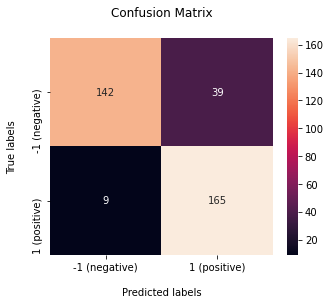

In [8]:
majority_vote = utils.vote_majority(L_test, 
                                    tie_policy = TIE_POLICY)
mv_scores = utils.score(y_test, 
                        majority_vote, 
                        verbose = True, 
                        plot_confusion = True)

## Snorkel scores


---------------------------------------------
tn, fp, fn, tp = [225  61   9 165]
F1             = 0.825
Accuracy       = 0.8478260869565217
Precision      = 0.7300884955752213
Recall         = 0.9482758620689655
ROC AUC        = 0.8674945743911261
Coverage       = 1.0
---------------------------------------------



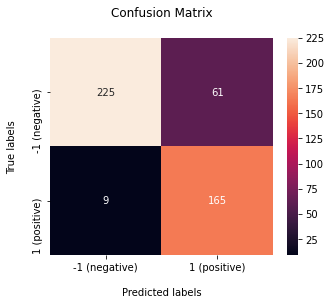

In [9]:
snorkel_scores = utils.score(y_test, 
                             df_test["Snorkel"], 
                             verbose = True, 
                             plot_confusion = True)


---------------------------------------------
tn, fp, fn, tp = [151   0   0 204]
F1             = 1.0
Accuracy       = 1.0
Precision      = 1.0
Recall         = 1.0
ROC AUC        = 1.0
Coverage       = 0.7717391304347826
---------------------------------------------



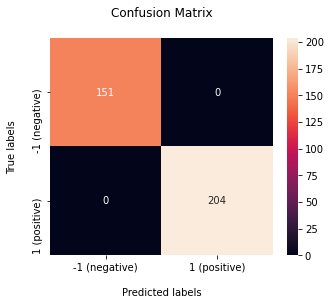

In [10]:
# Compare majority vote and Snorkel.
mv_v_snorkel_scores = utils.score(np.array(df_test["Snorkel"]), 
                                  majority_vote,
                                  verbose = True,
                                  plot_confusion = True)

## Dummy classifier scores

In [11]:
# Identify most abundant class.
df_train.Label.value_counts()

-1    1028
 1     628
Name: Label, dtype: int64


---------------------------------------------
tn, fp, fn, tp = [286   0 174   0]
F1             = 0.0
Accuracy       = 0.6217391304347826
Precision      = 0.0
Recall         = 0.0
ROC AUC        = 0.5
Coverage       = 1.0
---------------------------------------------



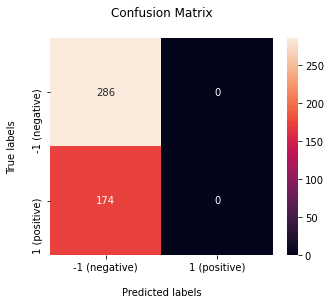

In [12]:
# Dummy classifier: label everything most abundant class.
dummy_scores = utils.score(y_test,
                           np.array([-1] * len(y_test)), 
                           verbose = True, 
                           plot_confusion = True)

## Define priors

### Empirical-based priors

In [13]:
# Parameters of best performing model yet.
# Target mean of Beta distribution.

# Known accuracies of each synthetic LF on the training set.
# NOTE: Demote 100% accuracies to 99.9999%, otherwise model cannot learn.
empirical_accuracies = [0.999999, 0.999999, 0.680556]

### Priors from majority vote

In [14]:
# Get priors from majority vote.
priors_mv = utils.get_priors_majority_vote(L_train, remove_zeros = True)
print("\npriors_mv_means =\n", priors_mv)
print("\nempirical accuracies =\n", empirical_accuracies)

l2_mv = np.linalg.norm(np.array(priors_mv) - np.array(empirical_accuracies))
print("\nL2 (priors_mv - empirical_accuracies) =", l2_mv)


# Estimated accuracies via majority vote = [0.999999, 0.999999, 0.9879608728367193]

priors_mv_means =
 [0.999999, 0.999999, 0.9879608728367193]

empirical accuracies =
 [0.999999, 0.999999, 0.680556]

L2 (priors_mv - empirical_accuracies) = 0.30740487283671925


### Manual priors

In [15]:
# Manually design priors.
priors_manual = [0.95] * 2 + [0.5]
print("\npriors_manual_means =\n", priors_manual)
print("\nempirical accuracies =\n", empirical_accuracies)

l2_mv = np.linalg.norm(np.array(priors_manual) - np.array(empirical_accuracies))
print("\nL2 (priors_manual - empirical_accuracies) =", l2_mv)


priors_manual_means =
 [0.95, 0.95, 0.5]

empirical accuracies =
 [0.999999, 0.999999, 0.680556]

L2 (priors_manual - empirical_accuracies) = 0.19390788828203978


## Explore untrained models

Zero training observations.


Untrained MAP score:

---------------------------------------------
tn, fp, fn, tp = [142  39   9 165]
F1             = 0.873015873015873
Accuracy       = 0.8647887323943662
Precision      = 0.8088235294117647
Recall         = 0.9482758620689655
ROC AUC        = 0.8664031244046485
Coverage       = 0.7717391304347826
---------------------------------------------



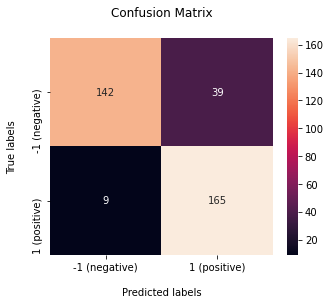

[0.8647887323943662,
 0.873015873015873,
 0.8088235294117647,
 0.9482758620689655,
 0.8664031244046485,
 0.7717391304347826]

In [16]:
MAP = BayesianDP(alpha = INIT_ALPHA_MAP,
                 beta = INIT_BETA,
                 priors_alpha = priors_mv,
                 prior_strength = STRENGTH)
pred_map = MAP.predict(L_test, 
                       return_proba = False, 
                       tie_policy = TIE_POLICY)
print("\nUntrained MAP score:")
utils.score(y_test, pred_map)

In [17]:
print("PRIOR PARAMS:")
for prior in MAP.priors_alpha:
    print(prior.concentration1, ",", prior.concentration0)

PRIOR PARAMS:
tensor(1000.) , tensor(0.0010)
tensor(1000.) , tensor(0.0010)
tensor(1000.) , tensor(12.1858)



Untrained MLE score:

---------------------------------------------
tn, fp, fn, tp = [142 144   9 165]
F1             = 0.6832298136645963
Accuracy       = 0.6673913043478261
Precision      = 0.5339805825242718
Recall         = 0.9482758620689655
ROC AUC        = 0.722389679286231
Coverage       = 1.0
---------------------------------------------



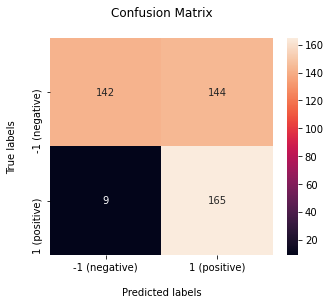

[0.6673913043478261,
 0.6832298136645963,
 0.5339805825242718,
 0.9482758620689655,
 0.722389679286231,
 1.0]

In [18]:
MLE = RatnerMLE(alpha = INIT_ALPHA_MAP,
                 beta = INIT_BETA)
pred_mle = MLE.predict(L_test, 
                       return_proba = False, 
                       tie_policy = TIE_POLICY)
print("\nUntrained MLE score:")
utils.score(y_test, pred_mle)

## Explore variance under low data

In [24]:
# Loop through different subset sizes.
# Scores = [acc, f1, precision, recall, roc, coverage].
sizes = [1, 5, 10, 50, 100, 500, 1000, L_train.shape[0]]
n_iter = 5
indices_by_size = dict()
for size in sizes:

    if size < 10:
        p_y = 0.5
        force_abstain = True
    else:
        p_y = 0.5
        force_abstain = False
    if size == L_train.shape[0]:
        n_iter = 1
    
    '''
    # Uncomment to reduce validation set size as well.
    if size < L_val.shape[0]:
        print("\n-*- REDUCING VAL SIZE -*-")
        val_indices = np.random.randint(0, high = L_val.shape[0], size = size)
        L_val_limited = L_val[val_indices, :]
        y_val_limited = y_val[val_indices]
        print("\nL_val_limited.shape =", L_val_limited.shape)
        print("y_val_limited.shape =", y_val_limited.shape)
        if size < 50:
            display(L_val_limited)
            display(y_val_limited)
    '''
    
    map_scores, mle_scores, majority_scores, subset_indices = trainer.loop_train_random_subset(L_train,
                                                                                               L_val,
                                                                                               y_val,
                                                                                               L_test, 
                                                                                               y_test,
                                                                                               INIT_ALPHA_MAP,
                                                                                               INIT_ALPHA_MLE,
                                                                                               INIT_BETA,
                                                                                               prior_strength = STRENGTH,
                                                                                               p_y = p_y,
                                                                                               force_abstain = force_abstain,
                                                                                               epochs_map = EPOCHS,
                                                                                               epochs_mle = EPOCHS,
                                                                                               learning_rate_map = LR_MAP,
                                                                                               learning_rate_mle = LR_MLE,
                                                                                               early_stopping = True,
                                                                                               patience = 5,
                                                                                               clip_grads = CLIP_GRADS,
                                                                                               verbose = False,
                                                                                               n_rows = size, 
                                                                                               n_iter = n_iter)
    # Store indices to rerun experiment if needed.
    indices_by_size[size] = subset_indices
    
    # Run supervised learning model.
    svm_scores = []
    for i in range(n_iter):
        y_train_svm = df_train_raw.iloc[list(subset_indices.get(i))]["Label"]
        # Can only compute if both labels present in training set.
        if np.unique(y_train_svm).shape[0] > 1:
            X_train_svm = df_train_raw.iloc[list(subset_indices.get(i))]["Title"]
            y_train_svm = np.array(y_train_svm, dtype = int)
            X_test_svm = df_test_raw["Title"]
            y_test_svm = np.array(df_test_raw["Label"], dtype = int)
            scores = trainer.train_test_score_svm(X_train_svm,
                                                  X_test_svm, 
                                                  y_train_svm, 
                                                  y_test_svm,
                                                  alpha = 1e-4)
            svm_scores.append(scores)
        else:
            svm_scores.append([0.0] * len(map_scores[0]))
    
    print("\n# -----------------------------------")
    print("# ---- SUBSET SIZE =", size)
    print("# -----------------------------------")
    print("\n# ---- MAP ----") 
    print("\n# [accuracy, f1, precision, recall, roc, coverage]")
    trainer.compute_variance(map_scores, "MAP", size)
    print("\n# ---- MLE ----")
    print("\n# [accuracy, f1, precision, recall, roc, coverage]")
    trainer.compute_variance(mle_scores, "MLE", size)
    print("\n#---- MAJORITY ----")
    print("\n# [accuracy, f1, precision, recall, roc, coverage]")
    trainer.compute_variance(majority_scores, "MAJ", size)
    print("\n#---- SUPPORT VECTOR MACHINE ----")
    print("\n# [accuracy, f1, precision, recall, roc, coverage]")
    trainer.compute_variance(svm_scores, "SVM", size)


# Estimated accuracies via majority vote = [0.999, 0.999, 0.999999]

--- EARLY STOPPING AT EPOCH 27 OF 175 ---


--- EARLY STOPPING AT EPOCH 56 OF 175 ---


# Estimated accuracies via majority vote = [0.999, 0.999999, 0.999999]

--- EARLY STOPPING AT EPOCH 27 OF 175 ---


--- EARLY STOPPING AT EPOCH 56 OF 175 ---


# Estimated accuracies via majority vote = [0.999, 0.999999, 0.999999]

--- EARLY STOPPING AT EPOCH 27 OF 175 ---


--- EARLY STOPPING AT EPOCH 56 OF 175 ---


# Estimated accuracies via majority vote = [0.999, 0.999, 0.999999]

--- EARLY STOPPING AT EPOCH 27 OF 175 ---


--- EARLY STOPPING AT EPOCH 56 OF 175 ---


# Estimated accuracies via majority vote = [0.999, 0.999, 0.999999]

--- EARLY STOPPING AT EPOCH 27 OF 175 ---


--- EARLY STOPPING AT EPOCH 56 OF 175 ---


# -----------------------------------
# ---- SUBSET SIZE = 1
# -----------------------------------

# ---- MAP ----

# [accuracy, f1, precision, recall, roc, coverage]

# Scores = [accuracy, f1, precision, re

### View indices for subsetting

In [25]:
indices_by_size

{1: {0: array([967]),
  1: array([635]),
  2: array([930]),
  3: array([735]),
  4: array([1591])},
 5: {0: array([  16, 1103, 1445,  161,  858]),
  1: array([1351, 1217,  296, 1494, 1338]),
  2: array([107, 744, 434,  94, 699]),
  3: array([1396, 1408,  330, 1072,  797]),
  4: array([ 473,  611, 1007,  209, 1333])},
 10: {0: array([1079,  981, 1612, 1081, 1195, 1245,  868,  638,  492,  637]),
  1: array([ 382, 1367, 1275,  789, 1388,  649, 1317,  910,  882, 1092]),
  2: array([ 782,  591, 1321, 1382, 1436,  338,  173,  600,  188,  131]),
  3: array([ 658,  238, 1052, 1627, 1164,  786,  564,  766,  938, 1163]),
  4: array([1155, 1025, 1549, 1057,  505,  660,  962,  725,  581,  582])},
 50: {0: array([ 156,  744,  790,  525, 1375,   60, 1091, 1183, 1035,  199,  288,
          702,   17,  281,   54,  561,  482,  944,  299,  292, 1632,  337,
          381,  649,   70, 1257,  648,  674,  667,  839, 1442,  382,  530,
          284,  272, 1069, 1431,  110,  413, 1136, 1555,  575, 1545,  785,

## End of document